<a href="https://colab.research.google.com/github/ghazalna/Stock-Price-Prediction-using-LSTM/blob/main/Stock_Price_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries**

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# **Load data**

In [9]:
data = pd.read_csv('/content/Download Data - STOCK_US_XNAS_META (1).csv')

In [10]:
data

,Date,Open,High,Low,Close,Volume
0,07/19/2024,476.06,486.71,475.71,476.79,"15,149,420"
1,07/18/2024,475.00,479.24,464.54,475.85,"19,267,160"
2,07/17/2024,479.17,479.17,459.12,461.99,"28,076,600"
3,07/16/2024,501.50,503.95,485.79,489.79,"14,075,830"
4,07/15/2024,498.63,506.68,493.37,496.16,"12,539,160"
...,...,...,...,...,...,...
248,07/25/2023,295.19,298.30,291.86,294.47,"19,585,580"
249,07/24/2023,295.78,297.52,288.30,291.61,"24,949,410"
250,07/21/2023,304.57,305.46,291.20,294.26,"42,139,262"
251,07/20/2023,313.50,315.54,302.22,302.52,"23,836,881"


In [13]:
# Reverse the data
data = data.iloc[::-1]

# Save the reversed index for later use
date = data.index
data

,Date,Open,High,Low,Close,Volume
252,07/19/2023,313.03,318.68,310.52,316.01,"21,763,689"
251,07/20/2023,313.50,315.54,302.22,302.52,"23,836,881"
250,07/21/2023,304.57,305.46,291.20,294.26,"42,139,262"
249,07/24/2023,295.78,297.52,288.30,291.61,"24,949,410"
248,07/25/2023,295.19,298.30,291.86,294.47,"19,585,580"
...,...,...,...,...,...,...
4,07/15/2024,498.63,506.68,493.37,496.16,"12,539,160"
3,07/16/2024,501.50,503.95,485.79,489.79,"14,075,830"
2,07/17/2024,479.17,479.17,459.12,461.99,"28,076,600"
1,07/18/2024,475.00,479.24,464.54,475.85,"19,267,160"


# **basic information about the data**

In [14]:
print(data.head())
print(data.info())

           Date    Open    High     Low   Close      Volume
252  07/19/2023  313.03  318.68  310.52  316.01  21,763,689
251  07/20/2023  313.50  315.54  302.22  302.52  23,836,881
250  07/21/2023  304.57  305.46  291.20  294.26  42,139,262
249  07/24/2023  295.78  297.52  288.30  291.61  24,949,410
248  07/25/2023  295.19  298.30  291.86  294.47  19,585,580
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 252 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    253 non-null    object 
 1   Open    253 non-null    float64
 2   High    253 non-null    float64
 3   Low     253 non-null    float64
 4   Close   253 non-null    float64
 5   Volume  253 non-null    object 
dtypes: float64(4), object(2)
memory usage: 12.0+ KB
None


# **Filter the data for the specified date range**

In [ ]:
#filtered_data = data.loc['2023-07-19':'2024-07-19']

# **Convert the 'Date' column to datetime**

In [15]:
data['Date'] = pd.to_datetime(data['Date'])

# **Extract the 'Close' column**

In [16]:
data.set_index('Date', inplace=True)
data = data[['Close']]  # Use the 'Close' column
data

,Close
Date,
2023-07-19,316.01
2023-07-20,302.52
2023-07-21,294.26
2023-07-24,291.61
2023-07-25,294.47
...,...
2024-07-15,496.16
2024-07-16,489.79
2024-07-17,461.99


In [17]:
data.shape

(253, 1)

# **Normalize the Data**

In [18]:
# Normalize the 'Close' prices to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# **Create training and testing datasets**

In [19]:
train_size = int(len(data_scaled) * 0.6)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [20]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step ):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [21]:
time_step = 4  # Number of previous days to consider
X_train, y_train = create_dataset(train_data, time_step )
X_test, y_test = create_dataset(test_data, time_step)

# **[samples, time steps, features]**

In [22]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# **Create the LSTM model**

In [23]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# **Compile the model**

In [24]:
model.compile(optimizer='adam',metrics=['accuracy'], loss='mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# **Train the model with the training data**

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.0023 - loss: 0.0767 - val_accuracy: 0.0000e+00 - val_loss: 0.2218
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0131 - loss: 0.0167 - val_accuracy: 0.0102 - val_loss: 0.0100
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0131 - loss: 0.0193 - val_accuracy: 0.0102 - val_loss: 0.0225
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0036 - loss: 0.0086 - val_accuracy: 0.0102 - val_loss: 0.0402
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0131 - loss: 0.0058 - val_accuracy: 0.0102 - val_loss: 0.0038
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0053 - loss: 0.0025 - val_accuracy: 0.0102 - val_loss: 0.0562
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0053 - loss: 0.0030 - val_accuracy: 0.0102 - val_loss: 0.0135
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0036 - loss: 0.0037 - val_accuracy: 0.0102 - val_

In [26]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


In [27]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# **Evaluate the model**

In [31]:
rmse = np.sqrt(np.mean((y_pred - y_test_actual) ** 2))
mae = mean_absolute_error(y_test_actual,y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'mean Absolute Error: {mae}')
r2=r2_score(y_test_actual,y_pred)
print("R2 Score :", r2)

Root Mean Squared Error: 15.828683080056884
mean Absolute Error: 11.8122646160515
R2 Score : 0.4939393736160298


In [33]:
last_4_days = data_scaled[-4:]
last_4_days = last_4_days.reshape((1, last_4_days.shape[0], 1))
predicted_close_price = model.predict(last_4_days)
predicted_close_price = scaler.inverse_transform(predicted_close_price)
print(f'Predicted Close Price on 07/22/2024: {predicted_close_price[0][0]}')       #$486.58

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Close Price on 07/22/2024: 484.39581298828125


In [39]:
last_8_days = data_scaled[-8:]
last_8_days = last_8_days.reshape((1, last_8_days.shape[0], 1))
predicted_close_price = model.predict(last_8_days)
predicted_close_price = scaler.inverse_transform(predicted_close_price)
print(f'Predicted Close Price on 07/26/2024: {predicted_close_price[0][0]}')         #$464.20

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Close Price on 07/27/2024: 474.22113037109375


In [40]:
last_12_days = data_scaled[-12:]
last_12_days = last_12_days.reshape((1, last_12_days.shape[0], 1))
predicted_close_price = model.predict(last_12_days)
predicted_close_price = scaler.inverse_transform(predicted_close_price)
print(f'Predicted Close Price on 07/30/2024: {predicted_close_price[0][0]}')      # $467.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Close Price on 07/30/2024: 461.079345703125


In [34]:
evaluate = model.evaluate(X_test, y_test)
print(evaluate)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0062 - loss: 0.0035     
[0.003803408471867442, 0.010204081423580647]


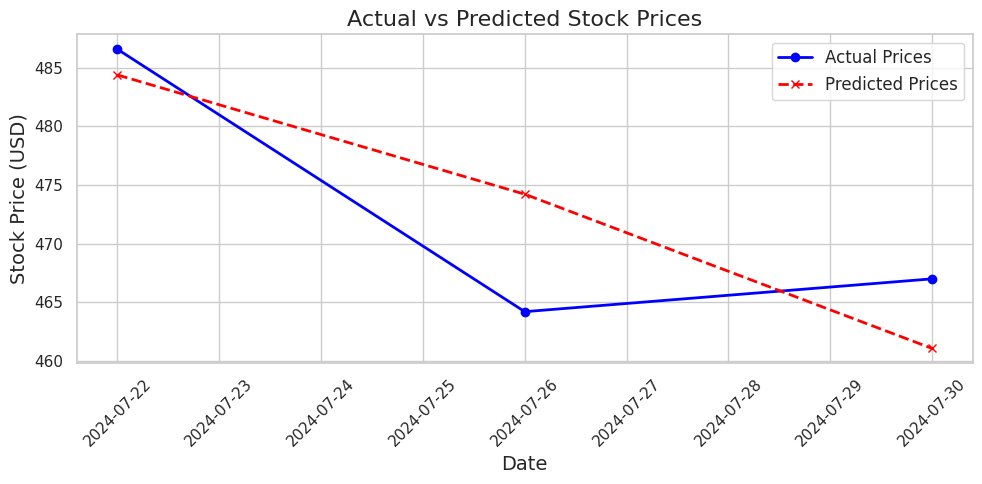

In [47]:
import seaborn as sns


# Sample data for actual and predicted prices
dates = ['07/22/2024', '07/26/2024', '07/30/2024']  # Provided dates
actual_prices = [486.58, 464.20, 467.00]
predicted_prices = [484.39, 474.22, 461.07]

# Convert dates to datetime format for better plotting
dates = pd.to_datetime(dates)

# Set the style for better visualization
sns.set(style="whitegrid")

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(dates, actual_prices, label='Actual Prices', color='blue', marker='o', linewidth=2)
plt.plot(dates, predicted_prices, label='Predicted Prices', color='red', linestyle='--', marker='x', linewidth=2)

# Add titles and labels
plt.title('Actual vs Predicted Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price (USD)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


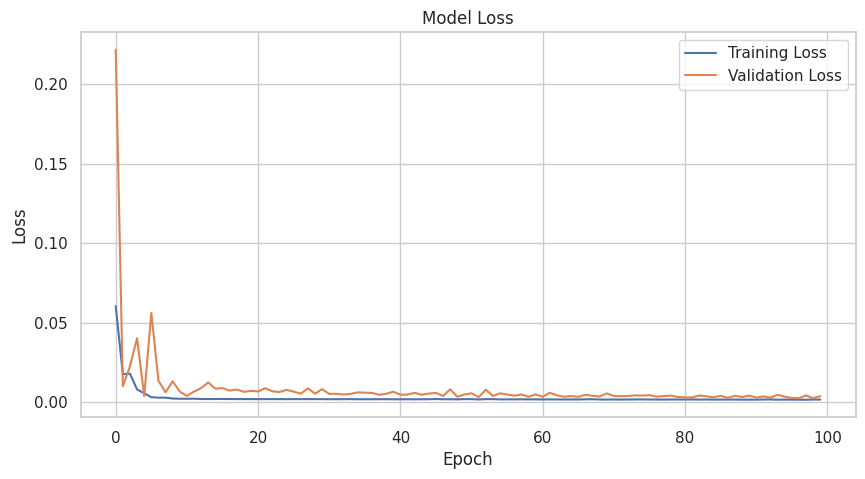

In [48]:

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
